In [1]:
import random
import numpy as np
from scipy.stats import multivariate_normal, norm
import matplotlib.pyplot as plt

### Flemin's function of second order model in python

In [2]:
def compute_meta_conf(xp, a, sigma_act, sigma_conf, rho):

    dhat = np.array([-1, 1])
    mu_x_xp_dhat = np.zeros((2, len(xp)))
    var_x_xp_dhat = np.zeros(len(xp))
    rho_vec = np.full(len(xp), rho)
    sigA_vec = np.full(len(xp), sigma_act)
    sigP_vec = np.full(len(xp), sigma_conf)
    
    Tol = 10e-4

    for dhati in range(2):
        dhat_vec = np.full(len(xp), dhat[dhati])
        
        mu_x_xp_dhat[dhati, :] = dhat_vec + (sigA_vec / sigP_vec) * rho_vec * (xp - dhat_vec)
        var_x_xp_dhat = (1 - rho_vec**2) * sigA_vec**2
        
        if a == 1:
            p_a_dhat_xp = 1 - norm.cdf(0, mu_x_xp_dhat[dhati, :], np.sqrt(var_x_xp_dhat))
        else:
            p_a_dhat_xp = norm.cdf(0, mu_x_xp_dhat[dhati, :], np.sqrt(var_x_xp_dhat))
        
        lik_d = norm.pdf(xp, dhat_vec, sigP_vec)
        
        if dhati == 0:
            p_a_dhat_xp_full = p_a_dhat_xp
            lik_d_full = lik_d
        else:
            p_a_dhat_xp_full = np.vstack((p_a_dhat_xp_full, p_a_dhat_xp))
            lik_d_full = np.vstack((lik_d_full, lik_d))
    
    # manage probability
    p_a_dhat_xp_full = np.clip(p_a_dhat_xp_full, Tol, None)
    lik_d_full = np.clip(lik_d_full, Tol, None)
    
    lik_d_full = lik_d_full / np.sum(lik_d_full, axis=0, keepdims=True)
    p_dhat_xp_a = p_a_dhat_xp_full * lik_d_full
    p_dhat_xp_a = p_dhat_xp_a / np.sum(p_dhat_xp_a, axis=0, keepdims=True)
    
    # Conf = p(a=d)
    if a == 1:
        conf = p_dhat_xp_a[1, :]
    else:
        conf = p_dhat_xp_a[0, :]
    
    return conf


### Try to simulate N consecutive trials. Without parameter updating over the time

In [6]:
theta = [0/6, 1/6, 2/6, 3/6, 4/6, 5/6, 6/6] # I changed a little, because is very easy so far 
sigmaAct = 2.5  # 1
sigmaConf = 2.5 # 1
rho = 0.5 # 0.5
bigSigma = np.array([[sigmaAct**2, rho * sigmaAct * sigmaConf], [rho * sigmaAct * sigmaConf, sigmaConf**2]])

N = 10  # N trials

xa = np.empty(N)
xp = np.empty(N)
d = np.empty(N)
a = np.empty(N)
secondOrder_mean_cor = np.empty(N)

for i in range(N):
    current_theta = random.choice(theta)
    
    d[i] = 1 if np.random.rand() > 0.5 else -1
    
    r = multivariate_normal.rvs(mean=[d[i] * current_theta, d[i] * current_theta], cov=bigSigma)
    
    xa[i] = r[0]
    xp[i] = r[1]
    
    if xa[i] > 0:
        a[i] = 1
        flip_a = 1
    else:
        a[i] = -1
        flip_a = 0
    
    secondOrder_mean_cor[i] = compute_meta_conf(np.array([xp[i]]), flip_a, sigmaAct, sigmaConf, rho)[0]

print("(d):", d)
print("(a):", a)
print("Second Order Confidences:", secondOrder_mean_cor)
print('xa ',xa)
print('xp ', xp)
#print(np.count_nonzero(d == a))
#print(np.count_nonzero(d != a))


(d): [-1. -1. -1.  1. -1.  1. -1.  1.  1.  1.]
(a): [-1. -1. -1.  1. -1.  1. -1. -1. -1.  1.]
Second Order Confidences: [0.58392    0.88506422 0.56487989 0.5825395  0.87358112 0.81443599
 0.68498483 0.39408613 0.55040912 0.78492948]
xa  [-2.10735818 -3.73430209 -0.03383444  1.85762489 -5.83002017  4.85541007
 -4.02333723 -0.4919414  -0.58663501  3.20041247]
xp  [ 0.12123184 -6.14757789  0.43188823 -0.14381417 -5.77682642  4.18513934
 -1.58670936  3.26962041  0.66716787  3.51930949]


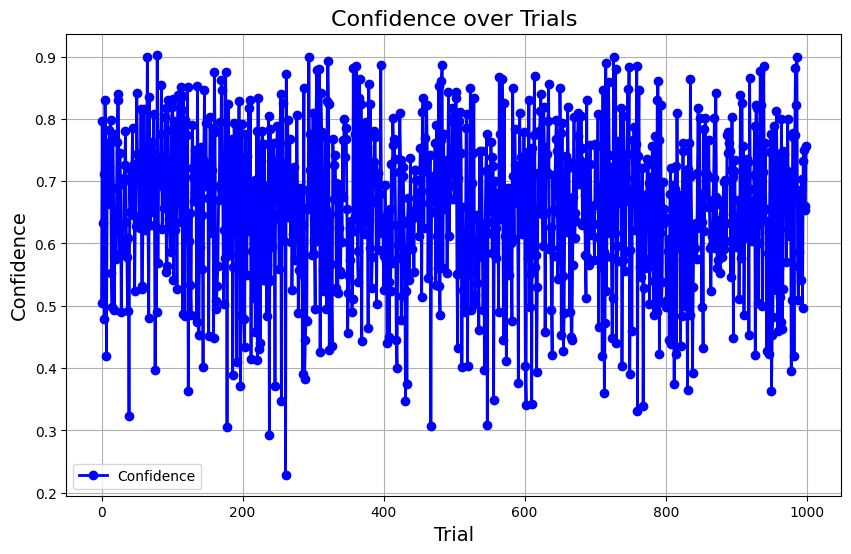

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(range(N), secondOrder_mean_cor, 'bo-', label='Confidence', linewidth=2)
plt.xlabel('Trial', fontsize=14)
plt.ylabel('Confidence', fontsize=14)
plt.title('Confidence over Trials', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

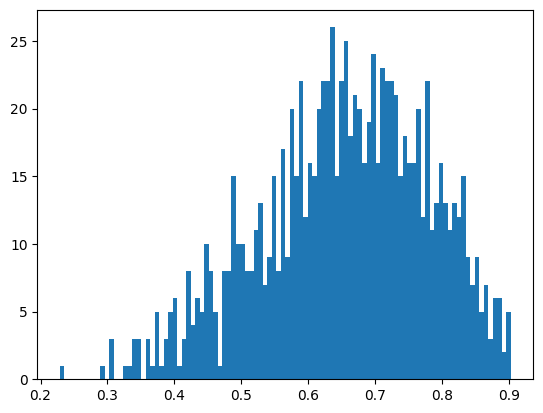

In [5]:
plt.hist(secondOrder_mean_cor, bins=100)
plt.show()

### I want to try serial dependece by weighted average 

In [61]:
###### FLEMING'S FUNCTION MODIFIED
def compute_meta_conf_serialdependence(xp, a, sigma_act, sigma_conf, rho, last_confidence = False):
    
    dhat = np.array([-1, 1])
    mu_x_xp_dhat = np.zeros((2, len(xp)))
    var_x_xp_dhat = np.zeros(len(xp))
    rho_vec = np.full(len(xp), rho)
    sigA_vec = np.full(len(xp), sigma_act)
    sigP_vec = np.full(len(xp), sigma_conf)
    
    Tol = 10e-4

    for dhati in range(2):
        dhat_vec = np.full(len(xp), dhat[dhati])
        
        mu_x_xp_dhat[dhati, :] = dhat_vec + (sigA_vec / sigP_vec) * rho_vec * (xp - dhat_vec)
        var_x_xp_dhat = (1 - rho_vec**2) * sigA_vec**2
        
        if a == 1:
            p_a_dhat_xp = 1 - norm.cdf(0, mu_x_xp_dhat[dhati, :], np.sqrt(var_x_xp_dhat))
        else:
            p_a_dhat_xp = norm.cdf(0, mu_x_xp_dhat[dhati, :], np.sqrt(var_x_xp_dhat))
        
        lik_d = norm.pdf(xp, dhat_vec, sigP_vec)
        
        if dhati == 0:
            p_a_dhat_xp_full = p_a_dhat_xp
            lik_d_full = lik_d
        else:
            p_a_dhat_xp_full = np.vstack((p_a_dhat_xp_full, p_a_dhat_xp))
            lik_d_full = np.vstack((lik_d_full, lik_d))
    
    # manage probability
    p_a_dhat_xp_full = np.clip(p_a_dhat_xp_full, Tol, None)
    lik_d_full = np.clip(lik_d_full, Tol, None)
    
    lik_d_full = lik_d_full / np.sum(lik_d_full, axis=0, keepdims=True)
    p_dhat_xp_a = p_a_dhat_xp_full * lik_d_full
    p_dhat_xp_a = p_dhat_xp_a / np.sum(p_dhat_xp_a, axis=0, keepdims=True)
    
    # Conf = p(a=d)
    if a == 1:
        conf = p_dhat_xp_a[1, :]
    else:
        conf = p_dhat_xp_a[0, :]

    print('Confianza sin modificar: ', conf )
    ## Conf affecte by last_confidence
    if last_confidence != 5:
        conf = last_confidence*0.5 + conf*0.5
    
    return conf

In [64]:
theta = [0/6, 1/6, 2/6, 3/6, 4/6, 5/6, 6/6] # I changed a little, because is very easy so far 
sigmaAct = 2.5  # 1
sigmaConf = 2.5 # 1
rho = 0.5 # 0.5
bigSigma = np.array([[sigmaAct**2, rho * sigmaAct * sigmaConf], [rho * sigmaAct * sigmaConf, sigmaConf**2]])

N = 4  # N trials

xa = np.empty(N)
xp = np.empty(N)
d = np.empty(N)
a = np.empty(N)
secondOrder_mean_cor = np.empty(N)
last_confidence = np.full(N, 5.0)

for i in range(N):
    current_theta = random.choice(theta)
    
    d[i] = 1 if np.random.rand() > 0.5 else -1
    
    r = multivariate_normal.rvs(mean=[d[i] * current_theta, d[i] * current_theta], cov=bigSigma)
    
    xa[i] = r[0]
    xp[i] = r[1]
    
    if xa[i] > 0:
        a[i] = 1
        flip_a = 1
    else:
        a[i] = -1
        flip_a = 0
    
    if i == 0:
        secondOrder_mean_cor[i] = compute_meta_conf_serialdependence(np.array([xp[i]]), flip_a, sigmaAct, sigmaConf, rho, last_confidence[i])[0]
    else:
        last_confidence[i] = secondOrder_mean_cor[i-1]
        secondOrder_mean_cor[i] = compute_meta_conf_serialdependence(np.array([xp[i]]), flip_a, sigmaAct, sigmaConf, rho, last_confidence[i])[0]

#print("(d):", d)
#print("(a):", a)
print("Second Order Confidences:", secondOrder_mean_cor)
#print('xa ',xa)
#print('xp ', xp)
print('last_confidence: ', last_confidence)
#print(np.count_nonzero(d == a))
#print(np.count_nonzero(d != a))

Confianza sin modificar:  [0.76836243]
Confianza sin modificar:  [0.6092962]
Confianza sin modificar:  [0.44648433]
Confianza sin modificar:  [0.43362903]
Second Order Confidences: [0.76836243 0.68882931 0.56765682 0.50064293]
last_confidence:  [5.         0.76836243 0.68882931 0.56765682]


In [43]:
N = 4  # N trials

xa = np.empty(N)
xp = np.empty(N)
d = np.empty(N)
a = np.empty(N)
secondOrder_mean_cor = np.empty(N)
last_confidence = np.empty(N)


In [60]:
last_confidence = np.full(N, 5)
last_confidence[0] != 5

False